In [277]:
#Levitation height distribution extraction analysis (for images with fluorescent channels)
#Last updated 17 April 2021.
#Author: Shreya Deshmukh, Stanford University.

#Runs as a jupyter notebook through anaconda (on python version 2.7)

#Import the following libraries
from os import listdir
from os.path import join
import numpy as np
import scipy.misc
from scipy import ndimage

from scipy import stats
from scipy.stats import moment, mode
import csv
import matplotlib.pyplot as plt
import cv2
import os.path
from PIL import Image
import skimage
from skimage.transform import resize
from scipy.signal import savgol_filter
%matplotlib inline

plt.rc('font',family='Arial')

#Define file path
#path = 'C:\\Users\\yourefiledirectories' #input the file path to where images are stored in the directory

os.listdir(path)

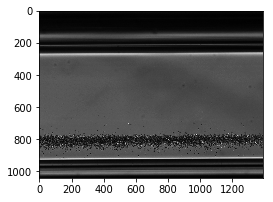

In [220]:
#(Start here if processing raw (uncropped) images. If pre-cropped images available, scroll down to the next "Import" stage.)
#Insert your filename here
img_title = "1_c1"

#Import image as RGB
img_bf = cv2.imread(os.path.join(path, img_title + "_c1.tif")) #replace with the relevant channel name and file extensions
img_fl = cv2.imread(os.path.join(path, img_title + "_c2.tif")) #replace with the relevant channel name and file extensions

#Convert from RGB to grey using OpenCV inbuilt command -brightfield
grey = cv2.cvtColor(img_bf, cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (4,4))
plt.imshow(grey, cmap = plt.get_cmap('gray')) #plt.show()

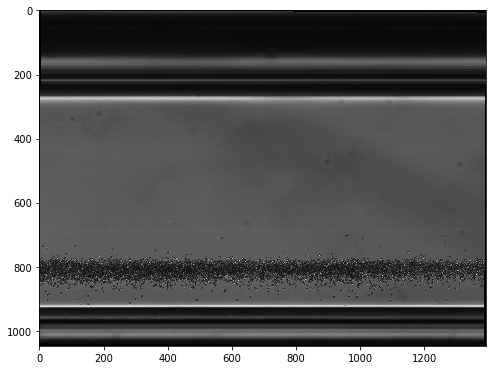

In [225]:
#Rotate image to parallel using scipy ndimage if needed (keep at 0 if already parallel)
rot_ang = -0.3 #degrees of rotation

#Rotate image using scipy ndimage -brightfield
rot = ndimage.rotate(grey, rot_ang)
plt.figure(figsize = (8,8))
plt.imshow(rot, cmap = plt.get_cmap('gray'))

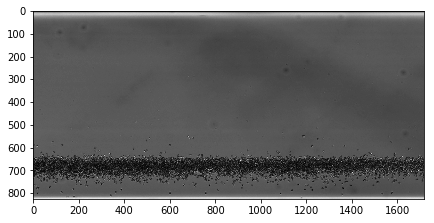

In [227]:
#Crop image to channel dimensions (removing extra space on top and bottom)
#Crop vertically using user-selected channel wall coordinates (depending on how the device was positioned for that image)

#Crop image to channel dimensions -brightfield 
#Crop vertically using user-selected channel wall coordinates
cropr_t = 265 #180
cropr_b = 660 + cropr_t #840
cropc_l = 10
cropc_r = rot.shape[1]-10 #for FlQuant i16
        
crop = rot[cropr_t:cropr_b,cropc_l:cropc_r]

#Choose one of the following resize settings, based on which microscope the image was captured on:
resized = skimage.transform.resize(crop, (int((cropr_b-cropr_t)*1.25),int((cropc_r-cropc_l)*1.25))) #for old microscope
#resized = skimage.transform.resize(crop, (int((cropr_b-cropr_t)*0.925),1689)) #for new microscope
#resized = skimage.transform.resize(crop, (int((cropr_b-cropr_t)*0.690),int((cropc_r-cropc_l)*0.690))) #for new microscope
#resized = skimage.transform.resize(crop, (int((cropr_b-cropr_t)*2.3),int((cropc_r-cropc_l)*2.3))) #skimage.transform.resize(crop, (int((cropr_b-cropr_t)*1.25),1267)) #for old microscope

plt.figure(figsize = (7,7))
plt.imshow(resized, cmap = plt.get_cmap('gray'))

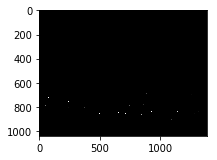

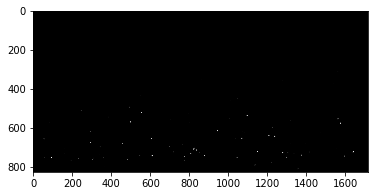

In [228]:
#For fluorescence -input crop dimensions and rotation angle from brightfield image earlier
#Convert from RGB to grey using OpenCV inbuilt command
greyf = cv2.cvtColor(img_fl, cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (3,3))
plt.imshow(greyf, cmap = plt.get_cmap('gray')) #plt.show()

#Rotate image using scipy ndimage
rotf = ndimage.rotate(greyf, rot_ang)
#plt.figure(figsize = (4,4))
#plt.imshow(rotf, cmap = plt.get_cmap('gray')) #plt.show()

#Crop image to channel dimensions
#Crop vertically using user-selected channel wall coordinates
cropf = rotf[cropr_t:cropr_b,cropc_l:cropc_r]
resizedf = skimage.transform.resize(crop, (int((cropr_b-cropr_t)*1.25),int((cropc_r-cropc_l)*1.25))) #for old microscope
#resizedf = skimage.transform.resize(crop, (int((cropr_b-cropr_t)*0.925),1689)) #for new microscope
#resizedf = skimage.transform.resize(crop, (int((cropr_b-cropr_t)*0.690),int((cropc_r-cropc_l)*0.690))) #for new microscope
#resizedf = skimage.transform.resize(crop, (int((cropr_b-cropr_t)*2.3),int((cropc_r-cropc_l)*2.3))) #skimage.transform.resize(crop, (int((cropr_b-cropr_t)*1.25),1267)) #for old microscope

plt.figure(figsize = (6,6))
plt.imshow(resizedf, cmap = plt.get_cmap('gray')) #plt.show()

In [229]:
#Save the cropped images
cropsav = cv2.convertScaleAbs(resized, alpha=(255.0))
cv2.imwrite("{}\{}_crop.tif".format(path,img_title), cropsav)

cropsavf = cv2.convertScaleAbs(resizedf, alpha=(255.0))
cv2.imwrite("{}\{}_cropf.tif".format(path,img_title), cropsavf)


True

In [230]:
#Import images
img_bf = cv2.imread(os.path.join(path, img_title + "_crop.tif")) 
resized = cv2.cvtColor(img_bf, cv2.COLOR_BGR2GRAY)

img_fl = cv2.imread(os.path.join(path, img_title + "_cropf.tif"))
resizedf = cv2.cvtColor(img_fl, cv2.COLOR_BGR2GRAY)

7.0


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  """


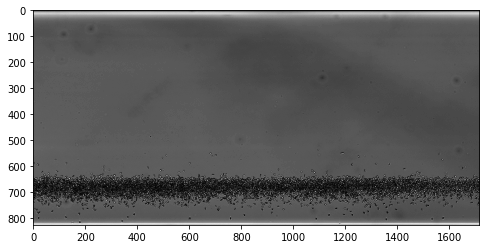

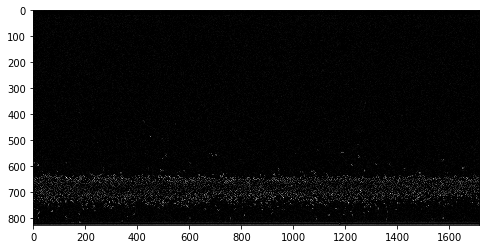

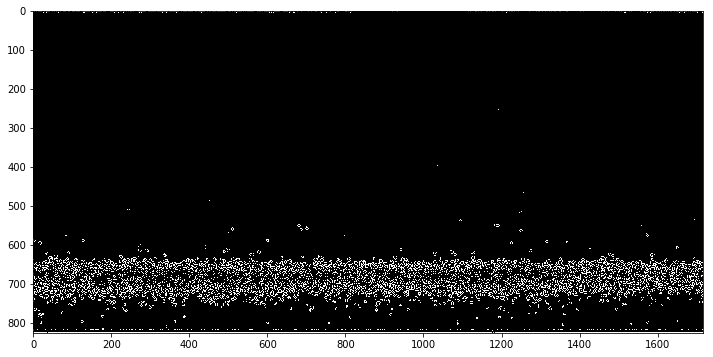

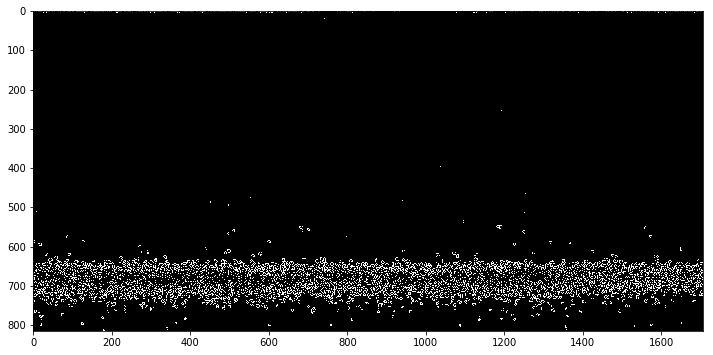

In [231]:
#Apply Gaussian smoothing -brightfield
blur = cv2.GaussianBlur(resized, (3,3), 2.7, 2.7)

from scipy.misc import bytescale
blur8 = bytescale(blur)
plt.figure(figsize = (8,8))
plt.imshow(blur8, cmap = plt.get_cmap('gray')) #plt.show()

#Apply Laplacian filter -with unadjusted image
smooth  = cv2.Laplacian(blur8, 8)
plt.figure(figsize = (8,8))
plt.imshow(smooth, cmap = plt.get_cmap('gray')) #plt.show()

#Binarise using Otsu's thresholding -brightfield
ret,th = cv2.threshold(smooth,0,1,cv2.THRESH_OTSU) #with Otsu's method, pos 2 is an arbitrary float, pos 3 is the max value desired in output, pos 4 selects the thresholding fcn
#ret,th = cv2.threshold(smooth,15,1,cv2.THRESH_BINARY) #with Otsu's method, pos 2 is an arbitrary float (default: 0), pos 3 is the max value desired in output (1), pos 4 selects the thresholding fcn
print ret

plt.figure(figsize = (12,12))
plt.imshow(th, cmap = plt.get_cmap('gray')) #plt.show()

cropper=10
plt.figure(figsize = (12,12))
plt.imshow(th[0:th.shape[0]-cropper,0:th.shape[1]-cropper], cmap = plt.get_cmap('gray')) #plt.show()

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  This is separate from the ipykernel package so we can avoid doing imports until


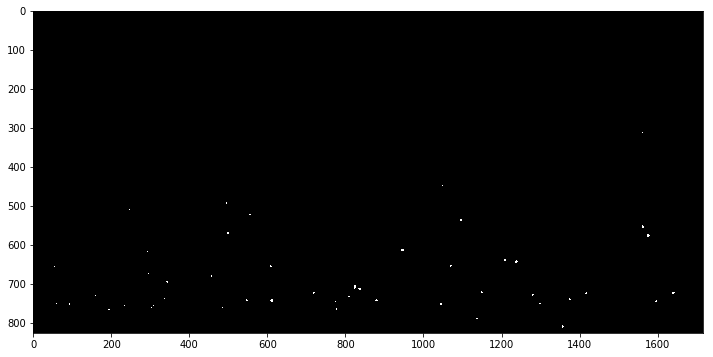

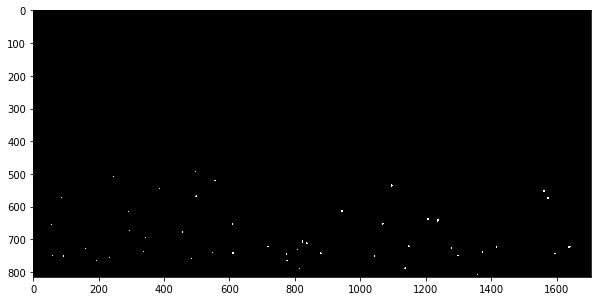

In [232]:
#Binarise using Otsu's thresholding -fluorescence
#FLUORESCENCE
resizedf8 = bytescale(resizedf)

retf,thf = cv2.threshold(resizedf8,0,1,cv2.THRESH_OTSU) #using THRESH_BINARY, since resizing makes the image need to be converted to 8-bit to work with Otsu, and it loses the required resolution
#thf = 1-thf

#retf,thf = cv2.threshold(resizedf8,40,1,cv2.THRESH_BINARY) #using THRESH_BINARY, since resizing makes the image need to be converted to 8-bit to work with Otsu, and it loses the required resolution
#thf = 1-thf

plt.figure(figsize = (12,12))
plt.imshow(thf, cmap = plt.get_cmap('gray')) #plt.show()

#cropper=10 #remove edge of image where binarisation adds a contrasting border artifact
plt.figure(figsize = (10,10))
plt.imshow(thf[0:thf.shape[0]-cropper,0:thf.shape[1]-cropper], cmap = plt.get_cmap('gray'))

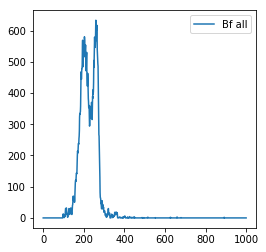

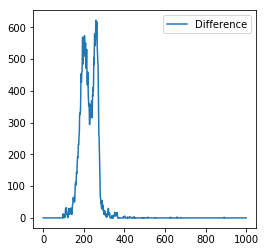

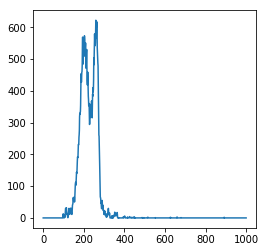

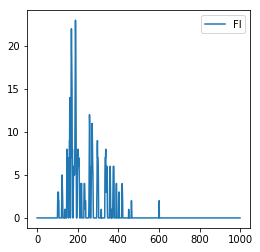

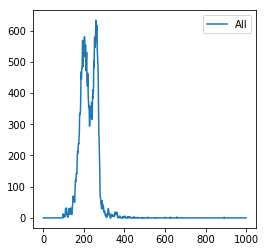

In [233]:
#Sum intensity values for each row (across the columns)
#cropper = 5
#FlUORESCENCE
n_rowsf = thf.shape[0]-cropper
intmatf = np.empty((n_rowsf,1))
for i in range(0,n_rowsf):
    intmatf[i] = sum(thf[i,0:th.shape[1]-cropper])

#Background noise subtraction
    
#Pad on bottom
intmatfpad = np.pad(intmatf, [(0, int(0.5*(1000-thf.shape[0]))+cropper), (0, 0)], mode='constant', constant_values=0)
    
#Reverse column order 
rev_intmatf = intmatfpad[::-1]
#Pad top with zeros (approx. 100) to make array height 1000
xp_fl = np.pad(rev_intmatf, [(0, 1000-rev_intmatf.shape[0]), (0, 0)], mode='constant', constant_values=0)

#Sum intensity values over rows
#BRIGHTFIELD
n_rowsb = th.shape[0]-cropper
intmatb = np.empty((n_rowsb,1))
for i in range(0,n_rowsb):
    intmatb[i] = sum(th[i,0:th.shape[1]-cropper])
    
#Background noise subtraction
intmatb[0:20]=0
intmat = intmatb
p_intmat = intmat
p_intmat[0:2]=0

#Pad 100 on bottom, and approx. 100 on top
p_intmatpad = np.pad(p_intmat, [(0, int(0.5*(1000-th.shape[0]))+cropper), (0, 0)], mode='constant', constant_values=0)

rev_intmatb = p_intmatpad[::-1]
#Pad top with zeros (approx. 100) to make array height 1000
xp_bf_all = np.pad(rev_intmatb, [(0, 1000-rev_intmatb.shape[0]), (0, 0)], mode='constant', constant_values=0)

#Accounting for double-counted pixels
xp_bf_minus = np.subtract(xp_bf_all, xp_fl)
xp_bf = xp_bf_minus
xp_bf[np.where(xp_bf_minus<0)]=0
xp_all = np.add(xp_bf,xp_fl)

#Plots
#Plot the different vectors (sanity check)
plt.figure(figsize=(4,4))
#plt.figure()
plt.plot(range(0,xp_fl.shape[0]), xp_bf_all, markersize=2, label = "Bf all")
plt.legend()
plt.figure(figsize=(4,4))
plt.plot(range(0,xp_fl.shape[0]), xp_bf_minus, markersize=2, label = "Difference")
plt.legend()
plt.figure(figsize=(4,4))
plt.plot(range(0,xp_fl.shape[0]), xp_bf, markersize=2, label = "Bf only")
plt.figure(figsize=(4,4))
plt.plot(range(0,xp_fl.shape[0]), xp_fl, markersize=2, label = "Fl")
plt.legend()
plt.figure(figsize=(4,4))
plt.plot(range(0,xp_fl.shape[0]), xp_all, markersize=2, label = "All")
plt.legend()

In [234]:
print sum(xp_bf_all)
print sum(xp_bf)
print sum(xp_fl)
print sum(xp_all)

#sanity check of errors at border

#Stack the values for all columns together
hts = np.column_stack((xp_bf_all,xp_bf,xp_fl,xp_all))

#Compute statistics for each distribution (mean, variance, skewness, kurtosis)
data_arr = hts
#Statistical analysis of heights
multilist = [None]*data_arr.shape[1]
for i in range(0,data_arr.shape[1]):
    hlist = []
    count = 1
    heights = data_arr[:,i]
    for h in heights:
        hlist = hlist + [count]*int(h)
        count = count+1
    multilist[i]=hlist
    
#Store statistical descriptors of these height distributions: columns are different sample types;
#Rows: mean, variance, skewness, kurtosis, standard deviation, median, mode
multistat = np.empty([4,data_arr.shape[1]])
for i in range(0,data_arr.shape[1]):
    multistat[:,i] = [np.mean(multilist[i]), np.var(multilist[i]), moment(multilist[i],moment=3), moment(multilist[i],moment=4)] #, np.sqrt(np.var(jlist)), np.median(jlist)]

print multistat

[51698.]
[50865.]
[902.]
[51767.]
[[2.24753898e+02 2.24779318e+02 2.35310421e+02 2.24962814e+02]
 [1.55481542e+03 1.49808068e+03 6.90513424e+03 1.59419316e+03]
 [4.40349009e+04 4.02284580e+04 5.26684473e+05 5.16485376e+04]
 [2.50680130e+07 2.43611496e+07 1.63390789e+08 2.72122571e+07]]


In [235]:
#Assign variables for storage
ms8 = multistat

In [276]:
#Save all variables into a csv file
ms_stack_pre = np.row_stack((ms1, ms2, ms3, ms4, ms5, ms6, ms7, ms8))
arr = np.array([range(0,8)])
mean_only = 4*arr
ms_stack = ms_stack_pre[mean_only[0,:],0:3]
yourfilename = str('ms3c_b')
np.savetxt('{}\{}.csv'.format(path,yourfilename), ms_stack, delimiter = ",", encoding = 'utf-8') 

In [274]:
print ms_stack

[[288.86800418 288.58135208 339.86353945]
 [244.54327426 244.47714125 286.22222222]
 [323.41381647 323.00313275 408.55208333]
 [230.01299767 229.82364021 262.3024    ]
 [280.75067611 280.50029168 293.14448336]
 [280.90041292 280.60899422 300.12290503]
 [283.01963335 282.40709751 308.16340426]
 [224.75389764 224.7793178  235.31042129]]


In [146]:
#Load saved data from CSV file
hts = np.array(list(csv.reader(open("yourfilename.csv", "rb"), delimiter=","))).astype("float")